In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

import pickle

from statsmodels.tsa.statespace.varmax import VARMAX
from random import random

from sklearn.metrics import mean_squared_error

# Cleaning and pre-processing

We use standardized log-return of the underlying price as our exogenous variable. 

In [2]:
data = pd.read_csv("final_data_v2.csv", parse_dates = [0])
data = data.set_index(data.columns[0])

raw = pd.read_csv("merged_options_data.csv", parse_dates = [2], index_col = 0)

p = raw['underlying_price'].iloc[np.where(np.diff(raw['date']).astype('int') != 0)]
p = p.append(raw['underlying_price'].iloc[-1:])
p = pd.DataFrame(p).set_index(data.index)
p['log_price'] = np.log(p['underlying_price'])
p['log_ret'] = np.insert(np.diff(p['log_price']), 0, 0)
p['log_ret_scaled'] = (p['log_ret'] - np.mean(p['log_ret'].values))/np.std(p['log_ret'].values)

# Model 1: VARMAX(1,1) using all data as training set
Here we use all data from 755 days as our training set, and use in-sample MSE as our performance criteria.

In [3]:
#model = VARMAX(data, exog=p['log_ret_scaled'], order=(1, 1))
#model_fit = model.fit(disp=False)
#filename = 'finalized_model_all_data.sav'
#pickle.dump(model_fit, open(filename, 'wb'))

In [4]:
filename = 'finalized_model_all_data.sav'
model_fit = pickle.load(open(filename, 'rb'))
pred = model_fit.predict()

In [5]:
model_fit.summary()

Dep. Variable:,"['-10-180', '-10-360', '-10-90', '-15-180', '-15-30', '-15-360', '-15-60', '-15-90', '-20-180', '-20-360', '-20-90', '-25-120', '-25-180', '-25-360', '-25-90', '-30-120', '-30-180', '-30-360', '-35-120', '-35-180', '-35-360', '-40-180', '-40-360', '-40-60', '-40-90', '-45-120', '-45-360', '-45-60', '-45-90', '-5-30', '-5-360', '-50-120', '-50-360', '-50-90', '0-360', '10-180', '10-360', '10-90', '5-360', '5-60']",No. Observations:,755
Model:,"VARMAX(1,1)",Log Likelihood,164122.358
,+ intercept,AIC,-320044.716
Date:,"Fri, 03 May 2019",BIC,-301075.173
Time:,11:35:34,HQIC,-312737.617
Sample:,0,,
,- 755,,
Covariance Type:,opg,,
Ljung-Box (Q):,"85.66, 105.13, 25.65, 42.31, 43.29, 51.05, 72.15, 83.93, 31.55, 43.43, 58.72, 67.52, 38.39, 38.11, 42.41, 58.96, 41.69, 45.19, 49.20, 48.53, 29.54, 89.85, 34.63, 34.02, 45.97, 80.07, 55.75, 56.43, 63.88, 49.11, 57.89, 34.38, 74.96, 82.71, 67.40, 42.56, 58.59, 64.72, 70.99, 50.67",Jarque-Bera (JB):,"96387.41, 125906.19, 3504.77, 155.70, 1169.12, 1020.37, 16.80, 211.89, 181.03, 227.69, 42.57, 40.94, 7880.72, 11044.27, 75.69, 36181.82, 2863.22, 732.66, 1077.85, 9916.80, 70.05, 9224.30, 1579.67, 65.30, 15.14, 49660.75, 3087.19, 4275.50, 79.96, 157.67, 28.39, 7589.46, 3191.75, 94.82, 342.46, 125.10, 14.22, 144.71, 58.47, 236.40"
Prob(Q):,"0.00, 0.00, 0.96, 0.37, 0.33, 0.11, 0.00, 0.00, 0.83, 0.33, 0.03, 0.00, 0.54, 0.56, 0.37, 0.03, 0.40, 0.26, 0.15, 0.17, 0.89, 0.00, 0.71, 0.74, 0.24, 0.00, 0.05, 0.04, 0.01, 0.15, 0.03, 0.72, 0.00, 0.00, 0.00, 0.36, 0.03, 0.01, 0.00, 0.12",Prob(JB):,"0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00"
Heteroskedasticity (H):,"1.78, 1.54, 2.16, 1.64, 1.04, 1.29, 0.92, 1.03, 1.21, 0.95, 0.79, 1.17, 1.81, 0.83, 0.72, 1.01, 1.87, 1.08, 1.09, 2.11, 1.08, 3.75, 1.86, 0.68, 0.58, 2.59, 2.19, 0.46, 0.38, 0.99, 1.67, 1.55, 3.10, 0.50, 2.62, 1.76, 0.98, 0.53, 1.06, 1.43",Skew:,"-3.81, 4.19, -0.22, -0.15, 0.67, -0.11, 0.19, -0.14, -0.27, 0.27, 0.20, -0.19, -0.52, -2.00, -0.14, -2.74, 1.27, 0.62, 0.46, 0.07, 0.09, -1.47, -0.61, -0.33, 0.01, 3.42, -0.95, 1.28, -0.34, 0.47, 0.06, -0.25, 0.64, -0.02, -0.07, -0.11, 0.17, -0.27, 0.01, 0.33"


In [7]:
print("The in-sample MSE is:", mean_squared_error(data, pred))

The in-sample MSE is: 0.0001156327707655379


/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


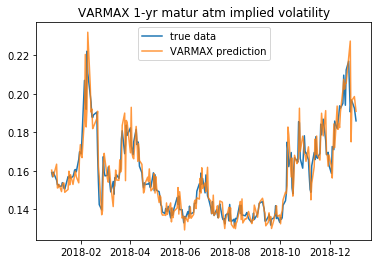

In [8]:
plt.plot(data.loc[:,'0-360'].iloc[500:], label = 'true data')
plt.plot(pred.loc[:,'0-360'].iloc[500:], label = 'VARMAX prediction', alpha = 0.8)
plt.legend()
plt.title('VARMAX 1-yr matur atm implied volatility')
#plt.show()
plt.savefig('VARMAX.jpg')

# Model 2: VARMAX(1,1) using first 2/3 data as training set
Here we use the first 2/3 data (500 days) as our training set, and make a 2-day forecast. Our perfermance criteria is the two-day forecast MSE. The reason why we only make a 2-day forecast is because 1) the training time is too long so we can't train the model on a rolling basis 2) the package does not support taking in new testing sets to make predictions, but can only make forecasts based on previous forecasts. We reckon that forecasts for a long time scale is not close to what we will get if training the model on a rolling basis. Therefore, we only take the results for a 2-day forecast.

In [9]:
#model_v2 = VARMAX(data.iloc[:500,], exog=p['log_ret_scaled'][:500], order=(1, 1))
#model_fit_capped = model_v2.fit(maxiter=5, disp=False)
#filename = 'finalized_model_capped_max_iter_5.sav'
#pickle.dump(model_fit_capped, open(filename, 'wb'))

In [10]:
filename = 'finalized_model_capped_max_iter_5.sav'
model_fit_capped = pickle.load(open(filename, 'rb'))
pred_capped = model_fit_capped.predict()

In [11]:
print("The in-sample MSE is:", np.mean(np.mean((pred_capped-data.iloc[:500,])**2)))

print("The two-day forecast result is:")
print(model_fit_capped.forecast(steps=2,exog = p.iloc[500:502, 3:4]))

The in-sample MSE is: 0.00023629691221009816
The two-day forecast result is:
      -10-180   -10-360    -10-90   -15-180    -15-30   -15-360    -15-60  \
500  0.164244  0.160263  0.166280  0.190571  0.257768  0.179772  0.213206   
501  0.167396  0.163314  0.169599  0.194318  0.262969  0.182958  0.217344   

       -15-90   -20-180   -20-360  ...    -5-360   -50-120   -50-360  \
500  0.200131  0.215211  0.198289  ...  0.138629  0.410242  0.302172   
501  0.204063  0.219223  0.201956  ...  0.141525  0.416803  0.308601   

       -50-90     0-360    10-180    10-360     10-90     5-360      5-60  
500  0.478040  0.156746  0.086707  0.111090  0.092932  0.131499  0.069993  
501  0.482012  0.158391  0.088055  0.112691  0.095259  0.133228  0.071650  

[2 rows x 40 columns]


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:152: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [13]:
print("The two-day forecast MSE is:", 
      mean_squared_error(data.iloc[500:502,], model_fit_capped.forecast(steps=2,exog = p.iloc[500:502, 3:4])))

The two-day forecast MSE is: 5.385389860015285e-05


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:152: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
